In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

from time import time

from scipy.special import comb, loggamma, lambertw
from scipy.stats import multinomial, expon

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import tensorflow_probability as tfp

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

import os, shutil
import json
import subprocess

from net_model import *
from custom_model import *
from mps_models import *

import mps
import pwexp

E0000 00:00:1741213943.483448 3230980 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741213943.487049 3230980 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1741213945.508781 3230980 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4118 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

i_valid_train = pd.Series(train_labels).isin([0,1,2,3,4]).to_numpy()
i_valid_test = pd.Series(test_labels).isin([0,1,2,3,4]).to_numpy()

# Filters to take only the images with labels in [0, 1, 2, 3, 4]
train_images = train_images[i_valid_train]
train_images = train_images / np.max(train_images)
train_shape = train_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
train_images = np.reshape(train_images, (train_shape[0], train_shape[1], train_shape[2], 1))

test_images = test_images[i_valid_test]
test_images = test_images / np.max(test_images)
test_shape = test_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
test_images = np.reshape(test_images, (test_shape[0], test_shape[1], test_shape[2], 1))

train_labels = train_labels[i_valid_train]
test_labels = test_labels[i_valid_test]

# Results

Now that all simulations have been performed, we will make an analysis of all the data and build the tables and graphics for the paper.

# Scenario 1 - Mostly lower cure probabilities

In this scenario, except for model RGP(q = -1/10), all models belong to the simpler "Power Series" distribution. In these cases, the theoretical model allow a cure probability take values through the entire the interval $(0,1)$ (or almost, given that in the RGP(q = -1/10), it varies from $(e^{-10}, 1)$. Even though, $e^{-10} \approx 0$). For the data generation, it was considered that each class of clothes has a different cure probability associated.

In the functions below, we recalculate from scratch the values for the cure probabilities and thetas from the models in order to compare with the previous values save in files and be sure that everything is in order. In the loading function, each fitted dataset in the simulations get its real and predicted values merges to make all the evaluation metrics easier to obtain.

In [3]:
cure_probs_dict1 = {0: 0.9, 1:0.45, 2:0.22, 3:0.14, 4: 0.08}
cure_probs_dict2 = {0: 0.95, 1:0.9, 2:0.85, 3:0.75, 4: 0.65}

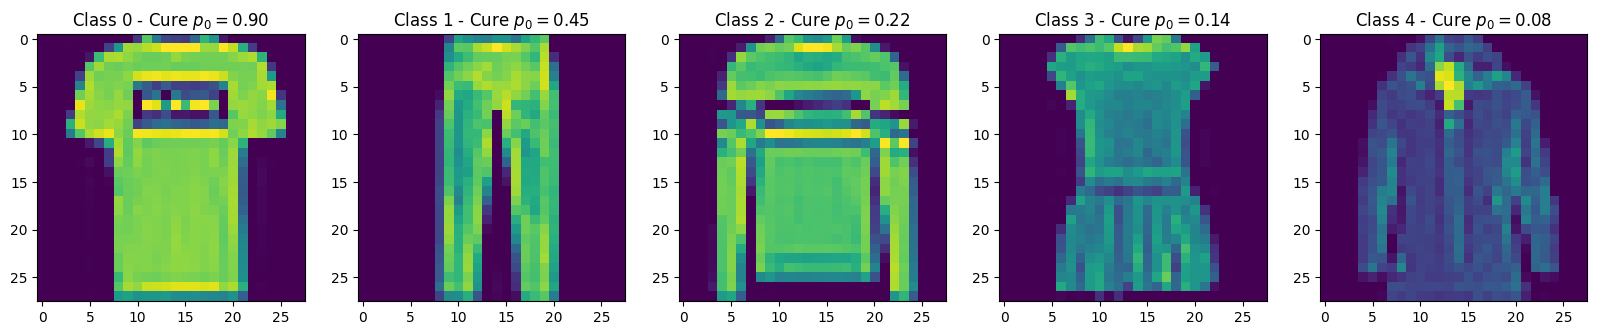

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20, 12))

for i in range(5):
    ax[i].imshow(train_images[ train_labels == i, :, : ][0])
    ax[i].set_title(r"Class {} - Cure $p_0 = {:.2f}$".format(i, cure_probs_dict1[i]))

plt.show()

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def ROC_real(cured, pred_p):
    fpr, tpr, thresholds = roc_curve(cured, pred_p, drop_intermediate = False)
    return fpr, tpr, thresholds

def AUC_real(cured, pred_p):
    fpr, tpr, thresholds = ROC_real(cured, pred_p)
    return auc(fpr, tpr)

def ROC_estimated(pred_p):
    thresholds = np.unique(pred_p)
    # Reshape the cure_probs array for broadcasting
    pred_p = np.reshape(pred_p, (len(pred_p), 1))
    tpr = np.sum( (pred_p < thresholds) * (1-pred_p), axis = 0 ) / np.sum( 1-pred_p )
    fpr = np.sum( (pred_p < thresholds) * pred_p, axis = 0 ) / np.sum( pred_p )
    return fpr, tpr, thresholds

def AUC_estimated(pred_p):
    fpr, tpr, thresholds = ROC_estimated(pred_p)
    return auc(fpr, tpr)

In [6]:
def load_fitted_model(n, scenario, distribution, q, train_images, test_images, train_labels, test_labels, cure_probs_dict, file_index):
    distribution_name = ''.join([i for i in distribution if not i.isdigit()])

    # Select the functions associated to the chosen distribution model
    log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max = select_model(distribution_name, q)
    log_a_tf = eval(log_a_str)
    log_phi_tf = eval(log_phi_str)
    C_tf = eval(C_str)
    C_inv_tf = eval(C_inv_str)
    sup_tf = eval(sup_str)

    data_path = "SimulationDataset/Scenario{}/n{}/{}".format(scenario, n, distribution)
    simulation_path = "SimulationResults/Scenario{}/n{}/{}/{}".format(scenario, n, distribution, file_index)
    indices_img = pd.read_csv("SimulationDataset/Scenario{}/n{}/indices_{}.csv".format(scenario, n, file_index))

    # ----------------------- Load generated data, such as the images for the requested simulation index -----------------------
    # Indices for the images associated to this specific sample
    train_val_imgs_indices = indices_img["index"][ (indices_img.set == "train") | (indices_img.set == "val") ].to_numpy()
    test_imgs_indices = indices_img["index"][ indices_img.set == "test" ].to_numpy()
    # Join all images in a single tensor
    train_val_imgs = train_images[train_val_imgs_indices, :, :, :]
    test_imgs = test_images[test_imgs_indices, :, :, :]
    imgs = np.concatenate([train_val_imgs, test_imgs])
    data = pd.read_csv("{}/data_{}.csv".format(data_path, file_index))
    
    # ----------------------- Load results related to the fitted simulation ----------------------- 
    fitted_model = MPScrModel(log_a_tf, log_phi_tf, C_tf, C_inv_tf, sup_tf)
    fitted_model.define_structure(shape_input = train_images[0].shape)
    fitted_model.load_model("{}/model.weights.h5".format(simulation_path))
    alpha_s_df = pd.read_csv("{}/alpha_s.csv".format(simulation_path))
    pred_alpha = alpha_s_df.alpha.to_numpy()
    real_alpha = np.ones_like(pred_alpha) # Because the real latent risk distribution is Exp(1), the real alphas is the vector of ones, for any vector s_t
    s_t = alpha_s_df.s.to_numpy()
    data_pred = pd.read_csv("{}/data_pred.csv".format(simulation_path))

    # ----------------------- Join everything in a single table -----------------------
    log_a_0 = log_a_tf(tf.constant(0.0, dtype = tf.float64))

    # Obtain all the predictions made using the trained model
    pred_eta = fitted_model.predict(imgs, verbose = 0)
    pred_p = fitted_model.link_func( pred_eta ).numpy().flatten()
    pred_log_p = np.log(pred_p)
    pred_theta = C_inv_tf( np.exp( log_a_0 - pred_log_p ) ).numpy().flatten()

    pred_m = update_m_mps(fitted_model, pred_alpha, s_t, imgs, data.t.to_numpy(), data.delta.to_numpy())
    
    # Indices where the observation is from train or validation
    indices_train_val = indices_img["set"].isin(["train", "val"])
    indices_test = indices_img["set"].isin(["test"])
    labels = np.zeros( len(pred_theta) )
    labels[ indices_train_val ] = train_labels[ indices_img.loc[ indices_train_val, "index" ].reset_index(drop = True) ]
    labels[ indices_test ] = test_labels[ indices_img.loc[ indices_test, "index" ].reset_index(drop = True) ]
    # Use the image labels to obtain the theoretical probabilities from the previous dictionary
    real_p = cure_probs_dict(labels)
    real_log_p = np.log(real_p)
    # Using the real p acquired, obtain the real theta values too
    real_theta = C_inv_tf( np.exp( log_a_0 - real_log_p ) )

    t = data.t.to_numpy()
    delta = data.delta.to_numpy()
    real_S1 = S1(t, real_alpha, s_t)
    pred_S1 = S1(t, pred_alpha, s_t)

    real_Spop = Spop_known_S1(real_S1, log_a_tf, log_phi_tf, real_theta, sup_tf)
    pred_Spop = Spop_known_S1(pred_S1, log_a_tf, log_phi_tf, pred_theta, sup_tf)
    
    df_summary = pd.DataFrame({"real_theta": real_theta, "real_p": real_p, "real_m": data.m.to_numpy(),
                               "pred_theta": pred_theta, "pred_p": pred_p, "pred_m": pred_m,
                               "t": t, "delta": delta,
                               "real_S1": real_S1, "pred_S1": pred_S1,
                               "real_Spop": real_Spop, "pred_Spop": pred_Spop,
                               "set": indices_img["set"].to_numpy()})
    
    return {
        "fit_model": fitted_model,
        "pred_alpha": pred_alpha,
        "pred_s_t": s_t,
        "real_alpha": real_alpha, # The real alpha vector is composed of all ones for any vector s_t - Exp(1)
        "imgs": imgs,
        "sets": indices_img["set"].to_numpy(),
        "log_a": log_a_tf,
        "log_phi": log_phi_tf,
        "C": C_tf,
        "C_inv": C_inv_tf,
        "sup": sup_tf,
        "summary": df_summary
    }

In [7]:
result = load_fitted_model(500, 1, "logarithmic", None, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict1.get), 1)
display( result["summary"] )

I0000 00:00:1741213954.963341 3230980 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4118 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1741213955.911429 3231112 service.cc:148] XLA service 0x788f78005170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741213955.911556 3231112 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
I0000 00:00:1741213955.953192 3231112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1741213956.480274 3231112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


,real_theta,real_p,real_m,pred_theta,pred_p,pred_m,t,delta,real_S1,pred_S1,real_Spop,pred_Spop,set
0,0.193100,0.90,0,0.455759,0.749157,0.052606,1.130386,0.0,0.322908,0.212128,0.929283,0.787888,train
1,0.988832,0.22,18,0.985127,0.234098,13.678279,0.027132,1.0,0.973232,0.933529,0.749769,0.641801,train
2,0.193100,0.90,0,0.273835,0.855793,0.000151,3.769457,0.0,0.023065,0.001100,0.902010,0.855922,train
3,0.999205,0.14,14,0.831860,0.466561,3.630418,0.096441,1.0,0.908064,0.822583,0.367049,0.786073,train
4,0.848131,0.45,1,0.792849,0.503618,4.505854,0.022834,1.0,0.977424,0.940882,0.958642,0.925127,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0.988832,0.22,8,0.952176,0.313193,5.236467,0.097257,1.0,0.907323,0.821358,0.557822,0.610151,test
712,0.988832,0.22,10,0.821674,0.476570,4.981760,0.024557,1.0,0.975742,0.937928,0.763393,0.910629,test
713,0.999996,0.08,765,0.992531,0.202680,106.385111,0.000608,1.0,0.999392,0.997793,0.759314,0.949571,test
714,0.988832,0.22,2,0.961391,0.295425,1.770995,0.693546,1.0,0.499801,0.390611,0.303435,0.370413,test


As it can be seen above, the function obtain all the desired quantities for the calculation of the goodness-of-fit metrics used in the paper. For each simulation, we will compute these metrics and, then, take the average through every replication.

In [8]:
def fitted_model_metrics(n, scenario, distribution, q, train_images, test_images, train_labels, test_labels, cure_probs_dict):

    Spop_mean_diffs, S1_mean_diffs, p_mean_diffs, m_mean_diffs = [], [], [], []
    auc_reals, auc_estimates = [], []
    for i in tqdm(range(1, 101)):
        result = load_fitted_model(n, scenario, distribution, q, train_images, test_images, train_labels, test_labels, cure_probs_dict, i)

        summary = result["summary"]
        summary_test = summary.loc[ summary["set"] == "test", : ]
        # If there are NaNs in the dataframe, the model did not converge and must be discarded
        if(np.any(summary_test.isna())):
            continue
        
        Spop_mean_diff = np.mean( (summary_test["real_Spop"] - summary_test["pred_Spop"])**2 )
        S1_mean_diff = np.mean( (summary_test["real_S1"] - summary_test["pred_S1"])**2 )
        p_mean_diff = np.mean( (summary_test["real_p"] - summary_test["pred_p"])**2 )
        m_mean_diff = np.mean( np.abs(summary_test["real_m"] - summary_test["pred_m"]) )
        auc_real = AUC_real( (summary_test["real_m"] == 0).astype(np.uint8), summary_test["pred_p"] )
        auc_estimated = AUC_estimated( summary_test["pred_p"] )

        Spop_mean_diffs.append(Spop_mean_diff)
        S1_mean_diffs.append(S1_mean_diff)
        p_mean_diffs.append(p_mean_diff)
        m_mean_diffs.append(m_mean_diff)

        auc_reals.append(auc_real)
        auc_estimates.append(auc_estimated)

    return {
        "Spop_mean_diffs": np.array(Spop_mean_diffs),
        "S1_mean_diffs": np.array(S1_mean_diffs),
        "p_mean_diffs": np.array(p_mean_diffs),
        "m_mean_diffs": np.array(m_mean_diffs),
        "auc_reals": np.array(auc_reals),
        "auc_estimates": np.array(auc_estimates),
        "delta_Spop": np.mean(Spop_mean_diffs),
        "delta_S1": np.mean(S1_mean_diffs),
        "delta_p": np.mean(p_mean_diffs),
        "delta_m": np.mean(m_mean_diffs),
        "auc_real_mean": np.mean(auc_reals),
        "auc_estimate_mean": np.mean(auc_estimates)
    }

In [9]:
def model_metrics_distribution(scenario, distribution, q, train_images, test_images, train_labels, test_labels, cure_probs_dict):
    metadata_500 = pd.read_csv("SimulationResults/Scenario{}/n{}/{}/sim_metadata.csv".format(scenario, 500, distribution))
    metadata_1000 = pd.read_csv("SimulationResults/Scenario{}/n{}/{}/sim_metadata.csv".format(scenario, 1000, distribution))
    metadata_3000 = pd.read_csv("SimulationResults/Scenario{}/n{}/{}/sim_metadata.csv".format(scenario, 3000, distribution))
    
    results_500 = fitted_model_metrics(500, scenario, distribution, q, train_images, test_images, train_labels, test_labels, cure_probs_dict)
    results_1000 = fitted_model_metrics(1000, scenario, distribution, q, train_images, test_images, train_labels, test_labels, cure_probs_dict)
    results_3000 = fitted_model_metrics(3000, scenario, distribution, q, train_images, test_images, train_labels, test_labels, cure_probs_dict)

    train_sizes = [500, 1000, 3000]
    delta_Spop = [results_500["delta_Spop"], results_1000["delta_Spop"], results_3000["delta_Spop"]]
    delta_S1 = [results_500["delta_S1"], results_1000["delta_S1"], results_3000["delta_S1"]]
    delta_p = [results_500["delta_p"], results_1000["delta_p"], results_3000["delta_p"]]
    delta_m = [results_500["delta_m"], results_1000["delta_m"], results_3000["delta_m"]]
    average_auc_real = [results_500["auc_real_mean"], results_1000["auc_real_mean"], results_3000["auc_real_mean"]]
    average_auc_estimate = [results_500["auc_estimate_mean"], results_1000["auc_estimate_mean"], results_3000["auc_estimate_mean"]]

    average_exec_time = [np.mean(metadata_500["execution_times"]), np.mean(metadata_1000["execution_times"]), np.mean(metadata_3000["execution_times"]) ]

    return pd.DataFrame({"average_execution_times": average_exec_time, "train_size": train_sizes,
                         "delta_Spop": delta_Spop, "delta_S1": delta_S1, "delta_p": delta_p, "delta_m": delta_m,
                         "average_auc_real": average_auc_real, "average_auc_estimate": average_auc_estimate})

# Scenario 1 Tables

In [10]:
print("Results - Poisson")
poisson_metrics = model_metrics_distribution(1, "poisson", None, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict1.get))
poisson_metrics.to_csv("SimulationTables/poisson.csv", index = False)
print("Results - Logarithmic")
logarithmic_metrics = model_metrics_distribution(1, "logarithmic", None, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict1.get))
logarithmic_metrics.to_csv("SimulationTables/logarithmic.csv", index = False)

Results - Poisson


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:24<00:00,  4.44s/it]


Results - Logarithmic


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:28<00:00,  4.49s/it]


In [10]:
print("Results - Geometric")
geometric_metrics = model_metrics_distribution(1, "geometric", None, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict1.get))
geometric_metrics.to_csv("SimulationTables/geometric.csv", index = False)
print("Results - Bernoulli")
bernoulli_metrics = model_metrics_distribution(1, "bernoulli", None, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict1.get))
bernoulli_metrics.to_csv("SimulationTables/bernoulli.csv", index = False)

Results - Geometric


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:16<00:00,  4.36s/it]


Results - Bernoulli


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


In [10]:
print("Results - Binomial(5)")
bin5_metrics = model_metrics_distribution(1, "bin5", 5.0, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict1.get))
bin5_metrics.to_csv("SimulationTables/bin5.csv", index = False)
print("Results - RGP(-1/10)")
rgp10_metrics = model_metrics_distribution(1, "rgp10", -1/10, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict1.get))
rgp10_metrics.to_csv("SimulationTables/rgp10.csv", index = False)

Results - Binomial(5)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


Results - RGP(-1/10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


In [29]:
print("Results - NB(1/2)")
mvnb2_metrics = model_metrics_distribution(1, "mvnb2", 1/2, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict1.get))
mvnb2_metrics.to_csv("SimulationTables/mvnb2.csv", index = False)

Results - NB(2)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:09<00:00,  4.89s/it]


# Scenario 2 Tables

In [10]:
print("Results - Borel")
borel_metrics = model_metrics_distribution(2, "borel", None, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict2.get))
borel_metrics.to_csv("SimulationTables/borel.csv", index = False)
print("Results - RPG(2)")
logarithmic_metrics = model_metrics_distribution(2, "rgp2", 2.0, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict2.get))
logarithmic_metrics.to_csv("SimulationTables/rgp2.csv", index = False)

Results - Borel


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:58<00:00,  4.18s/it]


Results - RPG(2)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:44<00:00,  4.05s/it]


In [10]:
print("Results - Haight")
haight_metrics = model_metrics_distribution(2, "haight", None, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict2.get))
haight_metrics.to_csv("SimulationTables/haight.csv", index = False)
print("Results - Geeta(3)")
geeta3_metrics = model_metrics_distribution(2, "geeta3", 3.0, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict2.get))
geeta3_metrics.to_csv("SimulationTables/geeta3.csv", index = False)

Results - Haight


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:18<00:00,  4.39s/it]


Results - Geeta(3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:16<00:00,  4.36s/it]


In [11]:
def model_metrics_distribution(scenario, distribution, q, train_images, test_images, train_labels, test_labels, cure_probs_dict):
    metadata_500 = pd.read_csv("SimulationResults/Scenario{}/n{}/{}/sim_metadata.csv".format(scenario, 500, distribution))
    metadata_1000 = pd.read_csv("SimulationResults/Scenario{}/n{}/{}/sim_metadata.csv".format(scenario, 1000, distribution))
    metadata_3000 = pd.read_csv("SimulationResults/Scenario{}/n{}/{}/sim_metadata.csv".format(scenario, 3000, distribution))
    
    # results_500 = fitted_model_metrics(500, scenario, distribution, q, train_images, test_images, train_labels, test_labels, cure_probs_dict)
    results_1000 = fitted_model_metrics(1000, scenario, distribution, q, train_images, test_images, train_labels, test_labels, cure_probs_dict)
    results_3000 = fitted_model_metrics(3000, scenario, distribution, q, train_images, test_images, train_labels, test_labels, cure_probs_dict)

    train_sizes = [1000, 3000]
    delta_Spop = [results_1000["delta_Spop"], results_3000["delta_Spop"]]
    delta_S1 = [results_1000["delta_S1"], results_3000["delta_S1"]]
    delta_p = [results_1000["delta_p"], results_3000["delta_p"]]
    delta_m = [results_1000["delta_m"], results_3000["delta_m"]]
    average_auc_real = [results_1000["auc_real_mean"], results_3000["auc_real_mean"]]
    average_auc_estimate = [results_1000["auc_estimate_mean"], results_3000["auc_estimate_mean"]]

    average_exec_time = [np.mean(metadata_1000["execution_times"]), np.mean(metadata_3000["execution_times"]) ]

    return pd.DataFrame({"average_execution_times": average_exec_time, "train_size": train_sizes,
                         "delta_Spop": delta_Spop, "delta_S1": delta_S1, "delta_p": delta_p, "delta_m": delta_m,
                         "average_auc_real": average_auc_real, "average_auc_estimate": average_auc_estimate})

In [12]:
print("Results - Geeta(3)")
geeta3_metrics = model_metrics_distribution(2, "geeta3", 3.0, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict2.get))
geeta3_metrics.to_csv("SimulationTables/geeta3.csv", index = False)

Results - Geeta(3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:32<00:00,  4.53s/it]


In [14]:
result = load_fitted_model(500, 2, "rgp2", 2, train_images, test_images, train_labels, test_labels, np.vectorize(cure_probs_dict2.get), 1)
display( result["summary"] )

,real_theta,real_p,real_m,pred_theta,pred_p,pred_m,t,delta,real_S1,pred_S1,real_Spop,pred_Spop,set
0,0.287682,0.75,0,0.307179,0.735519,0.000779,3.421700,0.0,0.032657,0.004676,0.754017,0.736092,train
1,0.430783,0.65,0,0.292909,0.746090,0.001887,2.499102,0.0,0.082159,0.011488,0.660102,0.747494,train
2,0.597837,0.55,48,0.301335,0.739830,6.309001,0.010800,1.0,0.989258,0.983235,0.978022,0.987889,train
3,0.430783,0.65,1,0.302225,0.739172,1.317746,0.982524,1.0,0.374365,0.293820,0.704102,0.780229,train
4,0.430783,0.65,2,0.296578,0.743358,1.376816,0.855542,1.0,0.425053,0.336081,0.713505,0.791220,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0.051293,0.95,0,0.307520,0.735268,0.000780,3.736545,0.0,0.023836,0.004676,0.951051,0.735841,test
712,0.051293,0.95,0,0.292738,0.746217,0.000765,4.932181,0.0,0.007211,0.004676,0.950317,0.746787,test
713,0.051293,0.95,0,0.308573,0.734494,0.008742,1.920932,0.0,0.146470,0.050733,0.956553,0.740832,test
714,0.430783,0.65,0,0.296563,0.743369,0.104582,0.592549,0.0,0.552916,0.443937,0.740755,0.810526,test


In [16]:
result["summary"]["real_theta"].unique()

array([0.28768207, 0.43078292, 0.597837  , 0.16251893, 0.05129329])